In [38]:
import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from statsmodels.tsa.statespace.sarimax import SARIMAX
from skforecast.model_selection_statsmodels import backtesting_sarimax
from skforecast.model_selection_statsmodels import grid_search_sarimax

from sktime.forecasting.arima import AutoARIMA

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from numpy import log
from matplotlib import pyplot

In [39]:
from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.tsa.ar_model import AutoReg
from pandas import date_range

In [40]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [41]:
from statsmodels.stats.diagnostic import acorr_ljungbox

Obrim el dataframe que vam crear en el preprocessat de dades.

In [100]:
df = pd.read_csv('db_df.csv')
df.head()

,Unnamed: 0,Nivell absolut (msnm),Percentatge volum embassat (%),Volum embassat (hm3),PPT
0,2000-01-01,147.27,50.8,31.02,0.0
1,2000-01-02,147.27,50.8,31.02,0.0
2,2000-01-03,147.27,50.8,31.02,0.0
3,2000-01-04,147.27,50.8,31.02,0.0
4,2000-01-05,147.28,50.8,31.04,0.0


Com que només farem servir finalment el nivell absolut en el nostres model, esborrarem la resta de les columnes.

In [101]:
df.drop(['Nivell absolut (msnm)'], axis = 'columns', inplace=True)
df.drop(['Volum embassat (hm3)'], axis = 'columns', inplace=True)
df.drop(['PPT'], axis = 'columns', inplace=True)

In [102]:
df.head()

,Unnamed: 0,Percentatge volum embassat (%)
0,2000-01-01,50.8
1,2000-01-02,50.8
2,2000-01-03,50.8
3,2000-01-04,50.8
4,2000-01-05,50.8


Com que les dates no s'han guardat al csv com a index si no com a columna, amb nom Unnamed: 0, haurem de transformar-la a format datetime per després fer-la servir com a index. finalment establim una freqüencia diaria del dataframe i esborrem la columna Unnamed: 0.

In [103]:
df['Dia'] = pd.to_datetime(df['Unnamed: 0'], format='%Y/%m/%d')
df = df.set_index('Dia')
df = df.asfreq('D')
df = df.sort_index()
df.drop(['Unnamed: 0'], axis = 'columns', inplace=True)

Renombrem la columna amb un nom més curt perque sigui més comode a l'hora de cridar-la.

In [104]:
df.rename({'Percentatge volum embassat (%)': 'Y'}, axis=1, inplace=True)

In [105]:
df.head()

,Y
Dia,
2000-01-01,50.8
2000-01-02,50.8
2000-01-03,50.8
2000-01-04,50.8
2000-01-05,50.8


Farem servir només les dades fins a l'1 de gener del 2022, per tenir una serie histórica amb anys sencers, que ens pot ajudar a l'hora de fer el model.

In [106]:
df = df.loc['2000-01-01':'2022-01-01']

Comprovem que el número de registres i el tipus de dades sigui el correcte.

In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8037 entries, 2000-01-01 to 2022-01-01
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Y       8037 non-null   float64
dtypes: float64(1)
memory usage: 125.6 KB


In [108]:
df.describe()

,Y
count,8037.000000
mean,59.601207
std,20.853724
min,21.900000
25%,41.700000
50%,60.400000
75%,78.500000
max,100.000000


## Analisi de la Serie Temporal

A continuació farem el test de Dickey–Fuller per comprovar la hipotesi que la serie és estacionaria.
Si el valor p dona per sota de 0.05 la hipotesi que la serie és estacionaria es certa i en cas contrari la rebutjem.

In [51]:
#Augmented Dickey–Fuller test:
print('Resultats del Dickey Fuller Test:')
dftest = adfuller(df)
adf = dftest[0]
pvalue = dftest[1]
critical_value = dftest[4]['5%']
if (pvalue < 0.05) and (adf < critical_value):
    print('P-Value: ',pvalue)
    print('La serie és estacionaria')
else:
    print('P-Value: ',pvalue)
    print('La serie NO és estacionaria')

Resultats del Dickey Fuller Test:
P-Value:  2.3313628690641097e-07
La serie és estacionaria


Dividim el dataframe en dos i veiem la diferencia en la mitjana i la variança entre els dos conjunts de dades.

In [52]:
X = df.values
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=52.955650, mean2=66.245111
variance1=426.494683, variance2=354.856748


Comprovem que no hi ha gaire diferencia en la mitjana i una mica més en la variança.

Com podem veure la serie té una mitjana i una variança que no varien gaire respecte a l'interval de temps de la serie que prenem, Lo que ens ve a confirmar que la serie és estacionaria tal i com hem vist al test de Dickey fuller. <br>
Que la serie sigui estacionaria és una condició bàsica per fer servir el model ARIMA. Si no fos estacionaria hauriem de transformar-la per convertirla en estacionaria.

Per un altre banda, com ja hem comprovat en el seasonal decompose de l'analisi gràfica, la serie  no té una tendencia clara i l'estacionalitat és d'uns 8 mesos aproximadament. Com que l'estacionalitat es propera a l'any i no hi ha dues estacions completes dintre d'un mateix any, en el cas del model ARIMA, es considera que no hi ha estacionalitat. Si l'estacionalitat fos trimestral, mensual, setmanal, diaria, horaria, etc.. podriem fer servir un model SARIMA, que té en compte aquests cicles com a estacions.

A continuació farem una gràfica d'autocorrelació i autocorrelació parcial (acf i pacf).

Primer en un periode d'un any:

/Users/david/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


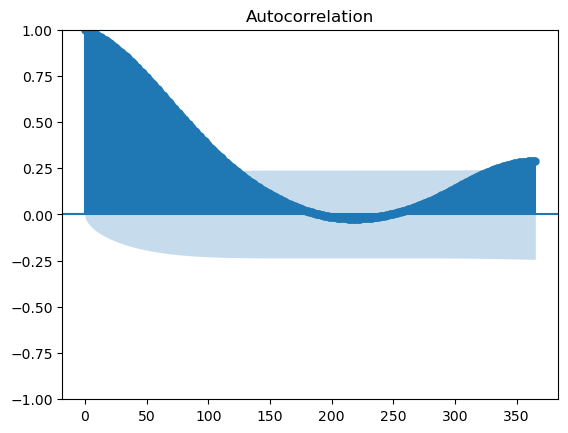

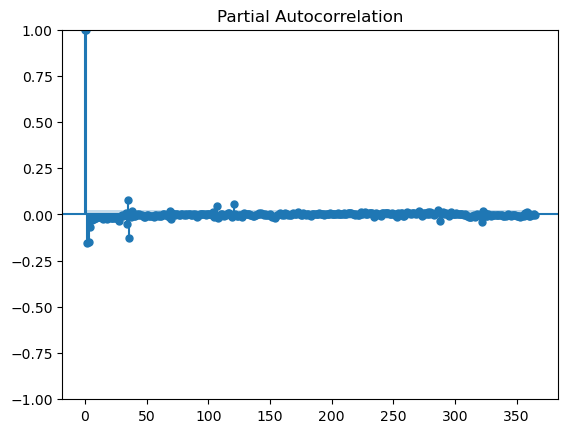

In [53]:
acf = plot_acf(df['Y'], lags=365)
pacf = plot_pacf(df['Y'], lags=365)

En aquesta gràfica comprovem que sí que hi ha autocorrelació en les dades, però no en una estació completa dintre d'un any. Veiem que es talla. Així doncs, farem la gràfica novament amb un periode de dos anys.

/Users/david/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


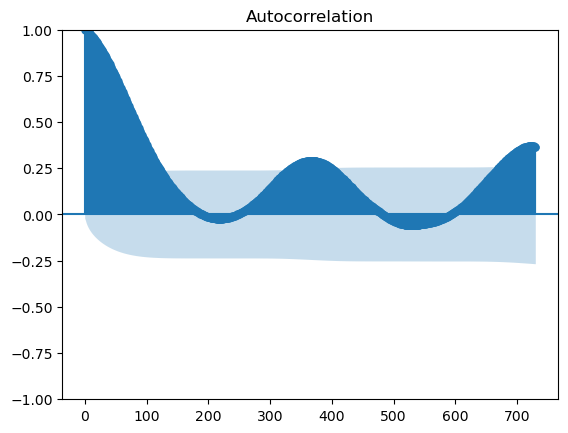

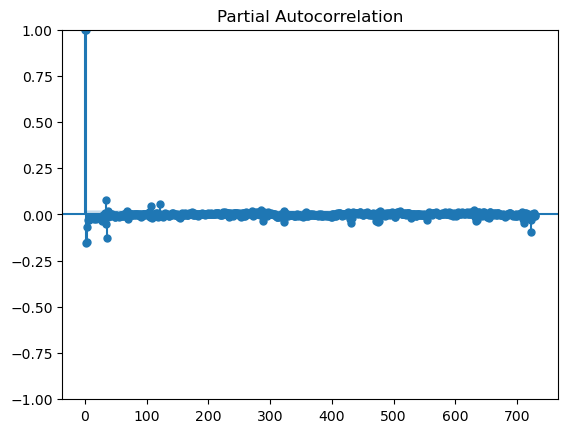

In [247]:
acf = plot_acf(df['Y'], lags=730)
pacf = plot_pacf(df['Y'], lags=730)

Aquí veiem autocorrelació en les dades en periodes de temps propers a l'any, com hem pogut comprovar en gràfiques anteriors.

A continuació farem una prova estadística per comprovar l'autocorrelació de les dades.

In [55]:
acorr_ljungbox(df, lags=365, return_df=True).head()

,lb_stat,lb_pvalue
1,8014.847830,0.0
2,15998.582060,0.0
3,23943.489119,0.0
4,31844.680344,0.0
5,39698.790266,0.0


Aquí veiem un valor p  més petit que .01, per tant podem rebutjar la hipòtesi nul·la, indicant que la sèrie temporal conté una autocorrelació.

## Model ARIMA

Separem les dades en conjunt de Train i test, amb un any de dades pel conjunt de test.

Fechas train : 2000-01-01 00:00:00 --- 2021-01-01 00:00:00  (n=7672)
Fechas test  : 2021-01-02 00:00:00 --- 2022-01-01 00:00:00  (n=365)


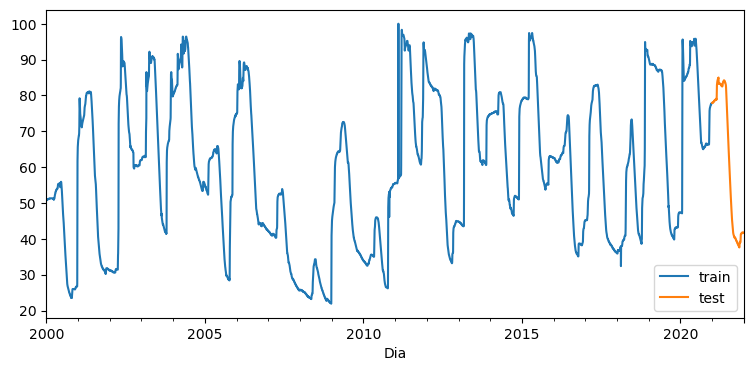

In [66]:
# Separació dades train-test
# ==============================================================================

steps = 365
train = df[:-steps]
test  = df[-steps:]

print(f"Fechas train : {train.index.min()} --- {train.index.max()}  (n={len(train)})")
print(f"Fechas test  : {test.index.min()} --- {test.index.max()}  (n={len(test)})")

# gràfica del train i test
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
train['Y'].plot(ax=ax, label='train')
test['Y'].plot(ax=ax, label='test')
ax.legend();

Farem servir la funció auto_arima que ens buscarà els millor paràmetres pel nostre model ARIMA.

In [67]:
model = pm.auto_arima(train, start_p=1, start_q=1, d=None, max_d=2,
                      max_p=12, max_q=12, 
                      m=1,           
                      seasonal=False,   
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      method='bfgs')

Performing stepwise search to minimize aic


/Users/david/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/david/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=23840.782, Time=2.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=24189.337, Time=0.19 sec


/Users/david/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=24034.130, Time=0.38 sec


/Users/david/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=24068.972, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=24187.407, Time=0.17 sec


/Users/david/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=23836.454, Time=8.21 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=23879.996, Time=0.57 sec


/Users/david/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=23852.877, Time=10.98 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=23834.426, Time=14.69 sec


/Users/david/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=23837.594, Time=8.32 sec


/Users/david/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=23838.615, Time=17.47 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=23835.174, Time=17.48 sec


/Users/david/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=23832.791, Time=14.20 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=23883.208, Time=2.25 sec


/Users/david/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=23826.829, Time=11.06 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=23867.791, Time=3.35 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=23831.770, Time=23.64 sec


/Users/david/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=23825.759, Time=23.28 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=23858.294, Time=5.44 sec
 ARIMA(2,1,5)(0,0,0)[0] intercept   : AIC=23830.089, Time=15.24 sec


/Users/david/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,6)(0,0,0)[0] intercept   : AIC=23818.921, Time=35.76 sec
 ARIMA(0,1,6)(0,0,0)[0] intercept   : AIC=23852.723, Time=7.54 sec
 ARIMA(2,1,6)(0,0,0)[0] intercept   : AIC=23845.682, Time=36.35 sec


/Users/david/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,7)(0,0,0)[0] intercept   : AIC=23859.159, Time=48.06 sec
 ARIMA(0,1,7)(0,0,0)[0] intercept   : AIC=23850.694, Time=9.27 sec
 ARIMA(2,1,7)(0,0,0)[0] intercept   : AIC=23815.941, Time=58.98 sec
 ARIMA(3,1,7)(0,0,0)[0] intercept   : AIC=23821.107, Time=50.10 sec
 ARIMA(2,1,8)(0,0,0)[0] intercept   : AIC=23835.512, Time=65.86 sec


/Users/david/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,8)(0,0,0)[0] intercept   : AIC=23847.580, Time=69.63 sec
 ARIMA(3,1,6)(0,0,0)[0] intercept   : AIC=23834.099, Time=50.23 sec
 ARIMA(3,1,8)(0,0,0)[0] intercept   : AIC=23819.845, Time=54.09 sec
 ARIMA(2,1,7)(0,0,0)[0]             : AIC=23813.449, Time=10.07 sec


/Users/david/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,7)(0,0,0)[0]             : AIC=23858.163, Time=11.00 sec
 ARIMA(2,1,6)(0,0,0)[0]             : AIC=23843.636, Time=9.40 sec
 ARIMA(3,1,7)(0,0,0)[0]             : AIC=23819.117, Time=9.75 sec
 ARIMA(2,1,8)(0,0,0)[0]             : AIC=23833.839, Time=12.08 sec


/Users/david/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,6)(0,0,0)[0]             : AIC=23816.901, Time=8.25 sec


/Users/david/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,8)(0,0,0)[0]             : AIC=23844.186, Time=14.29 sec
 ARIMA(3,1,6)(0,0,0)[0]             : AIC=23832.121, Time=11.28 sec
 ARIMA(3,1,8)(0,0,0)[0]             : AIC=23817.768, Time=12.68 sec

Best model:  ARIMA(2,1,7)(0,0,0)[0]          
Total fit time: 764.524 seconds


In [68]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 7672
Model:               SARIMAX(2, 1, 7)   Log Likelihood              -11896.724
Date:                Wed, 18 Jan 2023   AIC                          23813.449
Time:                        20:00:23   BIC                          23882.901
Sample:                    01-01-2000   HQIC                         23837.271
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4864      3.377      0.144      0.885      -6.133       7.106
ar.L2          0.4761      3.291      0.145      0.885      -5.974       6.927
ma.L1         -0.3788      3.377     -0.112      0.911      -6.998       6.241
ma.L2         -0.3913      2.927     -0.134      0.894      -6.129       5.346
ma.L3         -0.0360      0.109     -0.329      0.742      -0.250       0.178
ma.L4         -0.0527      0.177     -0.298      0.766      -0.400       0.295
ma.L5         -0.0217      0.093     -0.232      0.816      -0.205       0.161
ma.L6         -0.0114      0.038     -0.303      0.762      -0.085       0.062
ma.L7         -0.0123      0.046     -0.266      0.790      -0.103       0.079
sigma2         1.3094      0.001    958.558      0.000       1.307       1.312
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):         216288800.44
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                             5.46
Prob(H) (two-sided):                  0.00   Kurtosis:                       825.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Fem la predicció d'un periode d'un any perque coincideixi amb el conjunt de test i veure com s'ajusten les prediccions a la realitat.

In [90]:
prediction, confint = model.predict(n_periods=len(test), return_conf_int=True)

Generem un dataframe amb l'interval de confiança per poder graficar-lo.

In [92]:
cf= pd.DataFrame(confint)

Fem la gràfica amb la predicció de l'ultim any en taronja sobre la serie real, així com l'interval de confiança en gris.

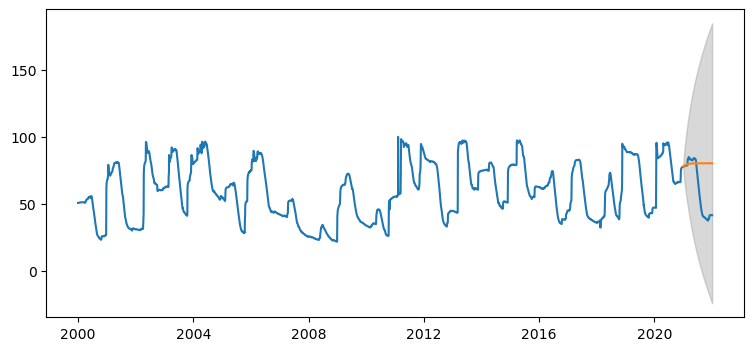

In [98]:
prediction_series = pd.Series(prediction,index=test.index)
fig, ax = plt.subplots(1, 1, figsize=(9, 4))
ax.plot(df)
ax.plot(prediction_series)
ax.fill_between(prediction_series.index,
                cf[0],
                cf[1],color='grey',alpha=.3)
fig.savefig('arima.png')

Veiem que la predicció, encara després d'haver escollit els millors parametres, no s'ajusta gens a la realitat. Així que en aquest cas no el podriem fer servir per fer noves prediccions d'aquesta serie temporal.

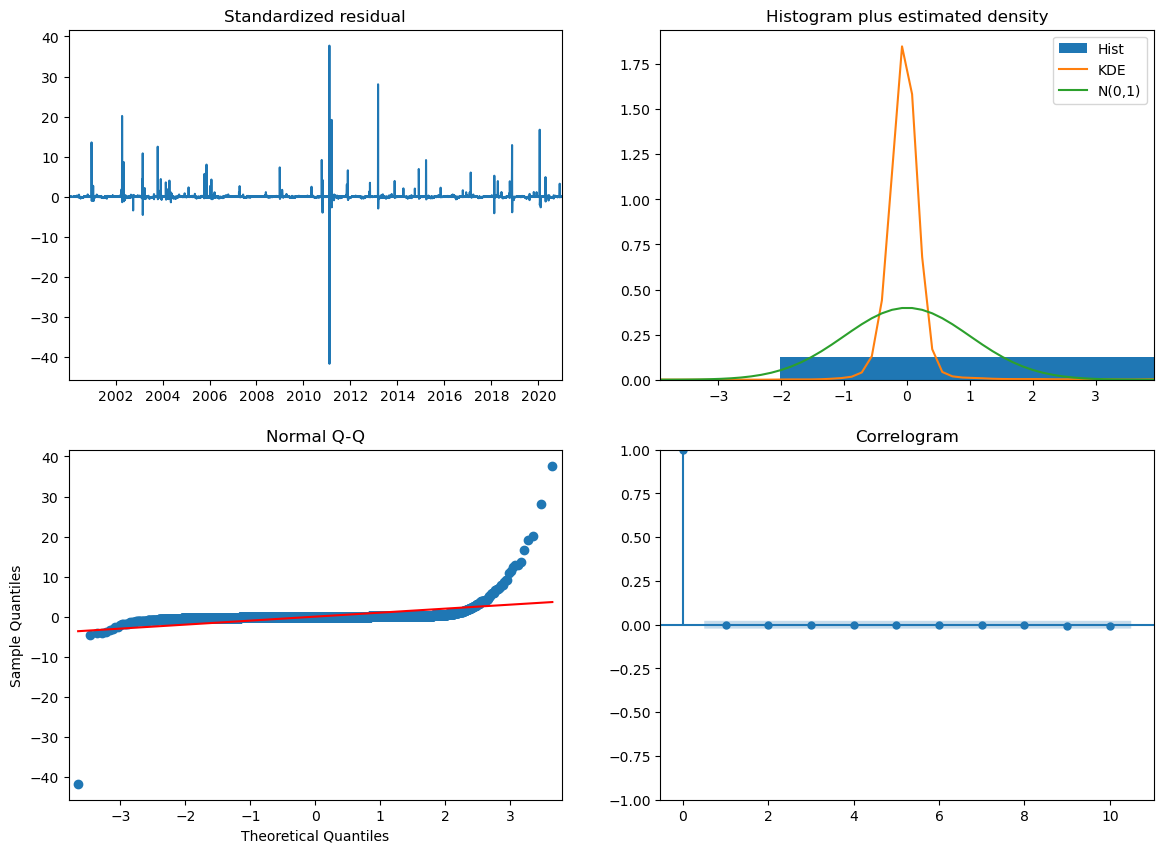

In [94]:
model.plot_diagnostics(figsize=(14,10))
plt.show()